In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

df = pd.read_csv("BMW_Cleaned_Preprocessed.csv")

x = df.drop(["Sales_Classification","Sales_Volume"], axis=1)
y = df["Sales_Classification"]

sm = SMOTE(random_state=42)
x_resampled, y_resampled = sm.fit_resample(x, y)

print("Class distribution after resampling:")
print(y_resampled.value_counts())

x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=42)

Class distribution after resampling:
Sales_Classification
0    34754
1    34754
Name: count, dtype: int64


In [4]:
from sklearn.ensemble import  VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


model_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

model_xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

voting_model = VotingClassifier(
    estimators=[("rf", model_rf), ("xgb", model_xgb)],
    voting="hard"
)

stacking_model = StackingClassifier(
    estimators=[("rf", model_rf), ("xgb", model_xgb)],
    final_estimator=LogisticRegression()
)

models = {
    "Random Forest": model_rf,
    "XGBoost": model_xgb,
    "Voting Classifier": voting_model,
    "Stacking Classifier": stacking_model
}


for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"\n {name} Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(classification_report(y_test, y_pred))



 Random Forest Accuracy: 73.98%
              precision    recall  f1-score   support

           0       0.86      0.58      0.69      6990
           1       0.68      0.91      0.78      6912

    accuracy                           0.74     13902
   macro avg       0.77      0.74      0.73     13902
weighted avg       0.77      0.74      0.73     13902


 XGBoost Accuracy: 73.46%
              precision    recall  f1-score   support

           0       0.81      0.61      0.70      6990
           1       0.69      0.86      0.76      6912

    accuracy                           0.73     13902
   macro avg       0.75      0.74      0.73     13902
weighted avg       0.75      0.73      0.73     13902


 Voting Classifier Accuracy: 72.72%
              precision    recall  f1-score   support

           0       0.79      0.63      0.70      6990
           1       0.69      0.83      0.75      6912

    accuracy                           0.73     13902
   macro avg       0.74      0.

In [5]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "n_estimators": [200, 300, 500],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

grid_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=params,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_xgb.fit(x_train, y_train)
print("\n Best Parameters:", grid_xgb.best_params_)

best_model = grid_xgb.best_estimator_
y_pred = best_model.predict(x_test)

print("\n Final Tuned XGBoost Model Accuracy:", accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

 Final Tuned XGBoost Model Accuracy: 74.71586822039994
              precision    recall  f1-score   support

           0       0.86      0.59      0.70      6990
           1       0.69      0.91      0.78      6912

    accuracy                           0.75     13902
   macro avg       0.77      0.75      0.74     13902
weighted avg       0.78      0.75      0.74     13902



C:\Users\AVI SHARMA\AppData\Local\Temp\ipykernel_18284\2840985386.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


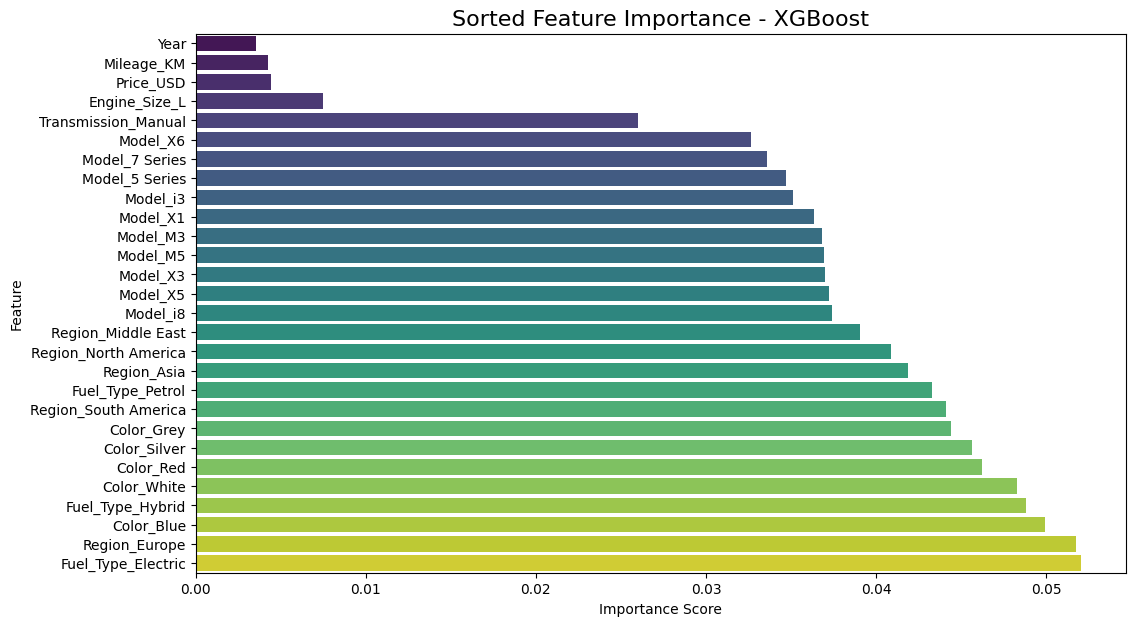

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(12,7))
sns.barplot(
    x=feature_importance[sorted_idx],
    y=x.columns[sorted_idx],
    palette=sns.color_palette("viridis", len(feature_importance))
)
plt.title("Sorted Feature Importance - XGBoost", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()